## Imports

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import cv2
print('cv2.__version__:', cv2.__version__)  # 4.1.2 recommended

import numpy as np
from IPython import display

import sys, platform
import ctypes, ctypes.util
import shutil

import threading
import time
import logging
logging.basicConfig(level=logging.DEBUG, format='(%(threadName)-10s) %(message)s')

from thread_camera import WebcamVideoStream

ctypes.util.find_library("libSystem.B.dylib")
print('shutil.which("libSystem.B.dylib"):', shutil.which("libSystem.B.dylib"))
print('ctypes.CDLL("libSystem.B.dylib")._name:', ctypes.CDLL("libSystem.B.dylib")._name)
print('ctypes.__version__:', ctypes.__version__)
print('platform.mac_ver():', platform.mac_ver())

(MainThread) Loaded backend module://ipykernel.pylab.backend_inline version unknown.


cv2.__version__: 4.1.2
shutil.which("libSystem.B.dylib"): None
ctypes.CDLL("libSystem.B.dylib")._name: libSystem.B.dylib
ctypes.__version__: 1.1.0
platform.mac_ver(): ('10.16', ('', '', ''), 'x86_64')


## Initialization

In [2]:
%tb

# https://solarianprogrammer.com/2019/07/18/python-using-c-cpp-libraries-ctypes/
mylib_path = ctypes.util.find_library("full_cpu")
if not mylib_path:
    print("Unable to find the specified library.")
    sys.exit()

try:
    jesture_lib = ctypes.CDLL(mylib_path)
except OSError:
    print("Unable to load the system C library")
    sys.exit()

No traceback available to show.


In [3]:
create_full_cpu = jesture_lib.CreateFullCpu
create_full_cpu.argtypes = [ctypes.c_int]
create_full_cpu.restype = ctypes.POINTER(ctypes.c_int)

run_full_cpu = jesture_lib.RunFullCpu
run_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
run_full_cpu.restype = None

stop_full_cpu = jesture_lib.StopFullCpu
stop_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
stop_full_cpu.restype = None

dispose_full_cpu = jesture_lib.DisposeFullCpu
dispose_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
dispose_full_cpu.restype = None

get_dynamic_gesture = jesture_lib.GetCurrentDynamicGesture
get_dynamic_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_dynamic_gesture.restype = ctypes.c_char_p

get_dynamic_gesture_idx = jesture_lib.GetCurrentDynamicGestureIdx
get_dynamic_gesture_idx.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_dynamic_gesture_idx.restype = ctypes.c_int

get_static_left_gesture = jesture_lib.GetCurrentStaticLeftGesture
get_static_left_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_static_left_gesture.restype = ctypes.c_char_p

get_static_right_gesture = jesture_lib.GetCurrentStaticRightGesture
get_static_right_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_static_right_gesture.restype = ctypes.c_char_p

# get_hand_left_keypoints = jesture_lib.GetCurrentHandLeftKeypoints
# get_hand_left_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
# get_hand_left_keypoints.restype = [ctypes.POINTER(ctypes.c_float)]

# get_hand_right_keypoints = jesture_lib.GetCurrentHandRightKeypoints
# get_hand_right_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
# get_hand_right_keypoints.restype = [ctypes.POINTER(ctypes.c_float)]

## Demo

In [4]:
def daemon():
    logging.debug('Starting')
    run_full_cpu(instance)
    logging.debug('Exiting')

In [5]:
def blur_image_patch(image, xmin, ymin, xmax, ymax, num_iter=5):
    patch = image[ymin:ymax, xmin:xmax, :]
    for i in range(num_iter):
        patch = cv2.blur(patch, (5, 5))
    image[ymin:ymax, xmin:xmax, :] = patch
    return image

def draw_text(image, text, org=(0, 185), font=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
              color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA, bottomLeftOrigin=False):
    image = cv2.putText(image, text, org, font, fontScale, 
                        color, thickness, lineType, bottomLeftOrigin)
    return image

In [6]:
# https://unicode.org/emoji/charts/emoji-list.html#1f44c
gesture_to_emoji = {
    '': '',
    '———': '———',
    'ONE': '\U0000261D',
    'TWO': 'TWO',
    'THREE': 'THREE',
    'FOUR': 'FOUR',
    'FIVE' : '\U0001F590',
    'OK': '\U0001F44C',
    'YEAH': '\U0000270C',
    'SPIDERMAN': '\U0001F91F',
    'ROCK': '\U0001F918',
    'FIST': '\U00009270A'
}

In [7]:
# !pip install emoji
import unicodedata
# in python2 use u'\U0001f603'
print('\U0001F44C')#U+1F44C
print(gesture_to_emoji['FIVE'])

👌
🖐


(MainThread) STREAM b'IHDR' 16 13
(MainThread) STREAM b'IDAT' 41 8192


True


(MainThread) findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
(M

(MainThread) findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Heavy.otf) normal normal heavy normal>) = 10.43
(MainThread) findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal medium normal>) = 11.145
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-BlackItalic.otf) italic normal black normal>) = 11.525
(MainThread) findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) norma

(1080, 1920)


(MainThread) findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal black normal>) = 10.525
(MainThread) findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Light.otf) normal normal light normal>) = 10.24
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-RegularItalic.otf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<F

(MainThread) findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal roman normal>) = 10.145
(MainThread) findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05
(MainThread) findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-UltralightItalic.otf) italic normal ultralight normal>) = 11.335
(MainThread) findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal medium normal>) = 10.145
(MainThread) findfont: score(<Font '

(MainThread) findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25
(MainThread) findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal light condensed>) = 10.44
(MainThread) findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Thin.otf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Light.otf) nor

(MainThread) findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Songti SC' (Songti.ttc) normal normal black normal>) = 10.525
(MainThread) findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal bold normal>) = 7.698636363636363
(MainThread) findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Times' (Times.ttc) normal normal roman normal>) = 10.145
(MainThread) findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'App

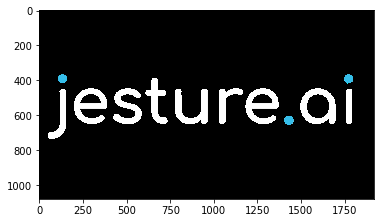

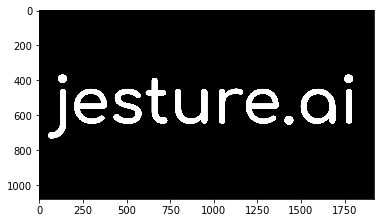

In [8]:
design_root = '/Users/izakharkin/Desktop/deepjest/_design'
logo_img_path = f'{design_root}/wix/jesture_ai_logo_comfortaa/jesture_logo_comfortaa-removebg.png'
img = Image.open(logo_img_path, 'r')
has_alpha = img.mode == 'RGBA'
print(has_alpha)
red, green, blue, alpha = img.split()
print(np.array(alpha).shape)
def to_np(pil_img):
    return np.array(pil_img)[...,None]
logo_img = np.concatenate([to_np(red), to_np(green), to_np(blue)], axis=-1)
alpha_img = to_np(alpha)
plt.imshow(logo_img);
plt.show();
plt.imshow(alpha_img[:,:,0], cmap='gray');
plt.show();

In [9]:
instance = create_full_cpu(1)
print(instance)
d = threading.Thread(name='daemon', target=daemon)
d.setDaemon(True)
d.start()

(daemon    ) Starting


In [10]:
# stop_full_cpu(instance)

In [11]:
name = 'JestureSDK: Python Demo'
width, height = (640, 480)
# cv2.namedWindow(name, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(name, (width, height))
# cv2.startWindowThread()

cap = WebcamVideoStream(src=1, width=width, height=height)
cap.start()

selfie_mode = True
i = 0
while(True):
    if cap.frame is None:
        continue
    frame = cap.frame[:,::-1,:] if selfie_mode else cap.frame  # TODO: read frames from dylib
#     frame = draw_logo_image(logo_img, )
    frame = blur_image_patch(frame, xmin=40, ymin=300, ymax=400, xmax=180)
    left_gesture = gesture_to_emoji[get_static_left_gesture(instance).decode()]
    right_gesture = gesture_to_emoji[get_static_right_gesture(instance).decode()]
    dynamic_gesture_idx = get_dynamic_gesture_idx(instance)
    frame = draw_text(
        frame, str(dynamic_gesture_idx), org=(width//2, height//4))
    frame = draw_text(
        frame, left_gesture, org=(width//10, height-height//4))
    frame = draw_text(
        frame, right_gesture, org=(width-width//10, height-height//4))
    cv2.imshow(name, frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        stop_full_cpu(instance)
        break
    i += 1

(daemon    ) Exiting


In [12]:
d.join()
print(instance)
dispose_full_cpu(instance)
print(instance)
cap.stop()

In [14]:
# cv2.waitKey(1)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

-1